#Problème n°1

La bonne transmission de signaux électromagnétiques dans l'atmosphère peut dépendre de la météo. La pluie affecte notoirement les échanges entre les antennes relais des réseaux mobiles actuels. C'est une gêne, mais aussi une opportunité: l'atténuation des ondes électromagnétiques due à la pluie peut être mesurée et utilisée comme un moyen de quantifier les précipitations.

Dans ce problème, on s'intéresse à la conversion de l'atténuation, définie comme un rapport entre puissance émise et puissance reçue et exprimée en dB, en un taux de pluie moyen le long de segments physiques dont les extrémités sont des paires d'antennes relais.

Evidemment, d'autres éléments que le pluie, plus ou moins bien connus, peuvent influencer l'atténuation. La simulation sur laquelle nous allons travailler, qui porte sur un millier de paires d'antennes virtuelles, est construite de la façon suivante:

- pour une paire d'antennes donnée, on modélise une série temporelle de taux de pluie moyen par un processus stochastique dont les paramètres dépendent entre autres de la distance qui sépare les antennes.
- pour en tirer des atténuations, on applique à cette série les transformations suivantes:
    - un filtre convolutif, censé modéliser l'impact du film d'eau se formant sur les antennes au cours d'un épisode de pluie.
    - une conversion non-linéaire, tirée d'un modèle physique, est appliquée composante à composante.
 épisode pluvieux (ce film qui s'épaissit augmente progressivement l'atténuation).
    - un bruit haute-fréquence
    - un bruit basse fréquence

La cellules suivantes permettent de récupérer les briques de code utiles, de construire un dictionnaire contenant des identifiants de paires d'antennes (clefs) et les distances les séparant (valeurs). La dernière cellule montre des exemples de séries temporelles simulées pour quelques paires.

In [1]:
# Local clone
! git clone https://github.com/nouhalahyen/exam_2025.git
! cp exam_2025/utils/utils_probleme1.py .

Cloning into 'exam_2025'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 99 (delta 17), reused 5 (delta 5), pack-reused 66 (from 2)
Receiving objects: 100% (99/99), 3.77 MiB | 18.84 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np
import sys
from utils_probleme1 import create_dataloader

In [3]:
# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création du dataloader (il contient toutes les étapes de la simulation)
# (en une époque, chaque paire d'antennes du dictionnaire idx2distance
# a été tirée exactement une fois)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)
valloader = create_dataloader(duration, idx2distance_val, batch_size)


# Génération d'un batch contenant des séries temporelles
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

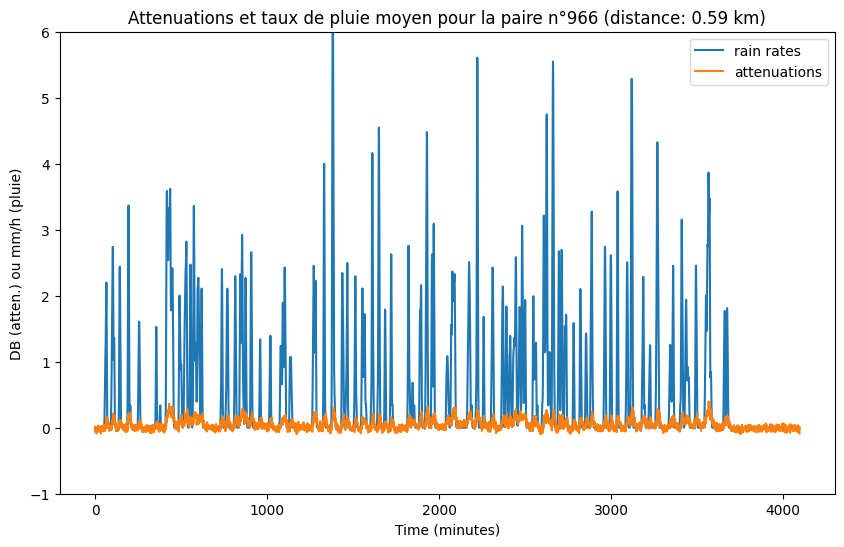

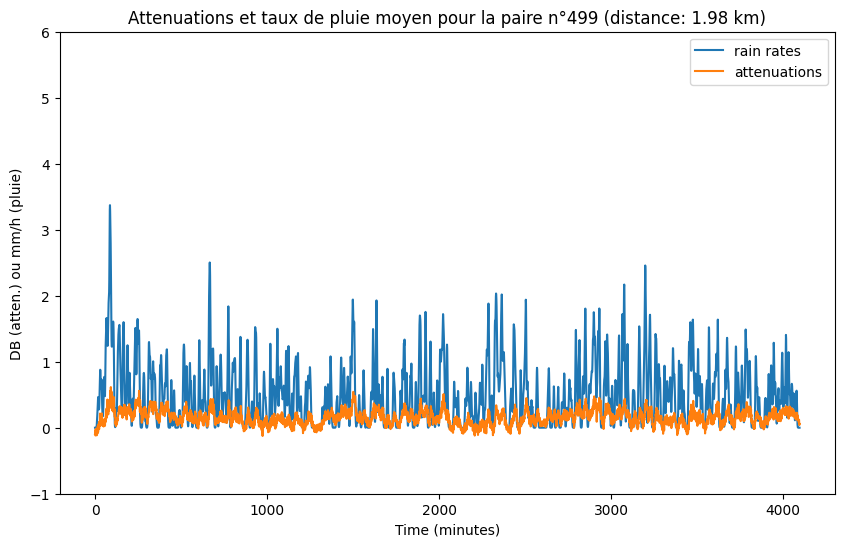

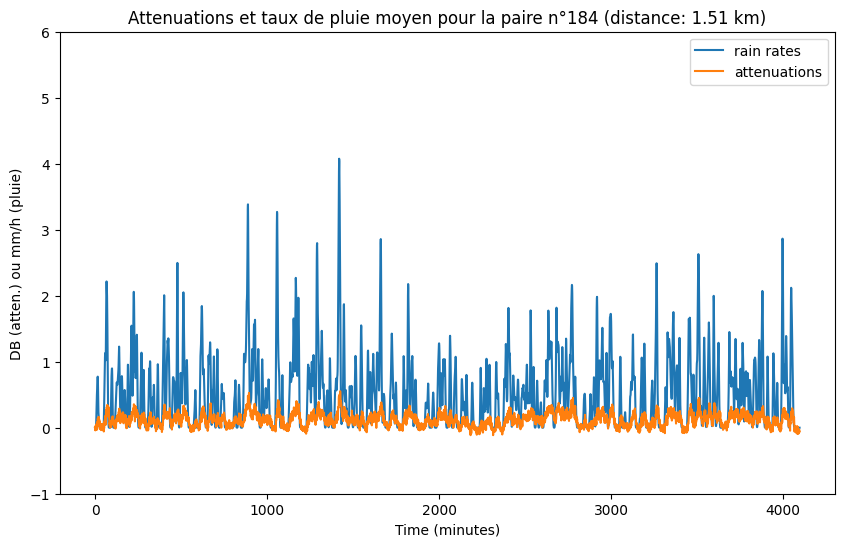

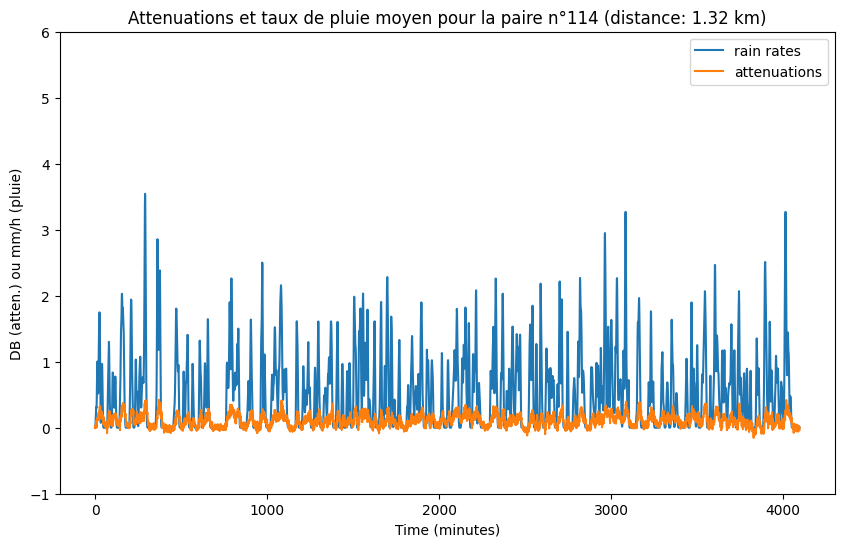

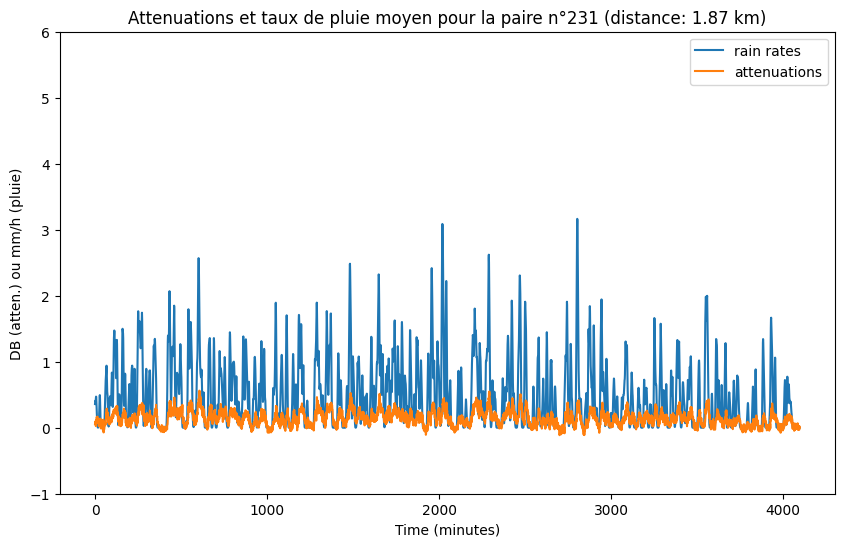

In [4]:
import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k], label='attenuations')
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

## Partie I : Un réseau de neurones générique

# A partir des briques de base

Dans cette partie, on entraîne un UNet1D à faire le lien entre atténuations
et taux de pluie. Les cellules suivantes contiennent les blocs du UNet1D et son montage :

In [5]:
##############################################################################################
################################     UNet 1D building blokcs    ##############################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


################################################################################
######################################## class UNet1D ##########################

class UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x

**Consignes:** \
1) Entraîner sur GPU un UNet 1D à restituer les taux de pluie à partir des atténuations.
- On utilisera la MSE comme fonction de coût et comme score. Dans les deux cas, prendre une marge de deux heures au début et à la fin de la série temporelle pour éviter les effets de bord.
- La descente de gradient stochastique sera pilotée par l'optimiseur ADAM (paramétrage standard) sur cinquante époques.

2) Tracer la courbe d'apprentissage de manière à montrer l'évolution:
- des performances en généralisation sur de nouvelles données issues des paires d'antennes vues à l'entraînement.
- des performances en généralisation sur des séries issues de paires d'antennes indépendantes (celles de *idx2distance_val*).


3) Visualiser les prédictions après apprentissage

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([100, 3856])) that is different to the input size (torch.Size([100, 1, 3856])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Train Loss: 0.9463, Val Loss: 0.7262
Epoch 2/50, Train Loss: 0.6446, Val Loss: 0.6118
Epoch 3/50, Train Loss: 0.5956, Val Loss: 0.5149
Epoch 4/50, Train Loss: 0.5881, Val Loss: 0.5098
Epoch 5/50, Train Loss: 0.5834, Val Loss: 0.5064
Epoch 6/50, Train Loss: 0.5791, Val Loss: 0.5062
Epoch 7/50, Train Loss: 0.5816, Val Loss: 0.5654
Epoch 8/50, Train Loss: 0.5850, Val Loss: 0.5055
Epoch 9/50, Train Loss: 0.5798, Val Loss: 0.5062
Epoch 10/50, Train Loss: 0.5815, Val Loss: 0.5073
Epoch 11/50, Train Loss: 0.5925, Val Loss: 0.5074
Epoch 12/50, Train Loss: 0.5765, Val Loss: 0.5122
Epoch 13/50, Train Loss: 0.5787, Val Loss: 0.5143
Epoch 14/50, Train Loss: 0.5846, Val Loss: 0.5137
Epoch 15/50, Train Loss: 0.5827, Val Loss: 0.5075
Epoch 16/50, Train Loss: 0.5876, Val Loss: 0.5079
Epoch 17/50, Train Loss: 0.5830, Val Loss: 0.5056
Epoch 18/50, Train Loss: 0.5892, Val Loss: 0.5059
Epoch 19/50, Train Loss: 0.5836, Val Loss: 0.5017
Epoch 20/50, Train Loss: 0.5821, Val Loss: 0.5090
Epoch 21/

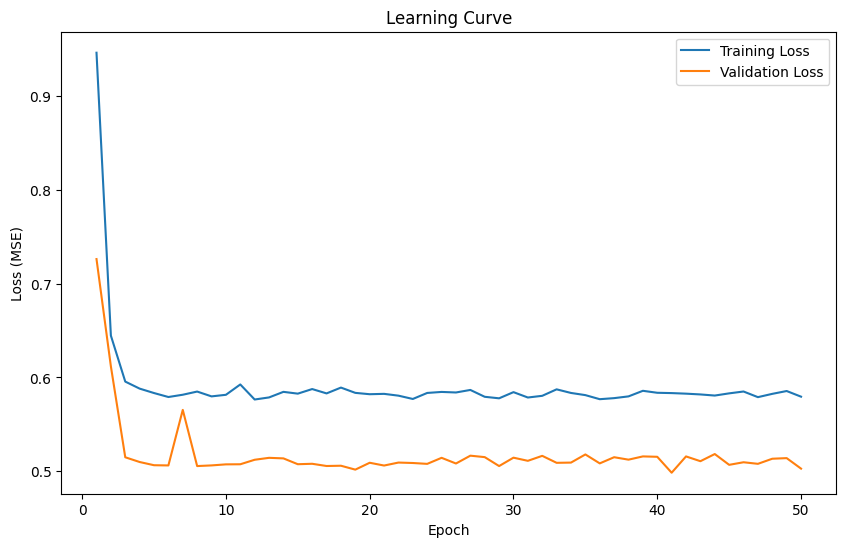

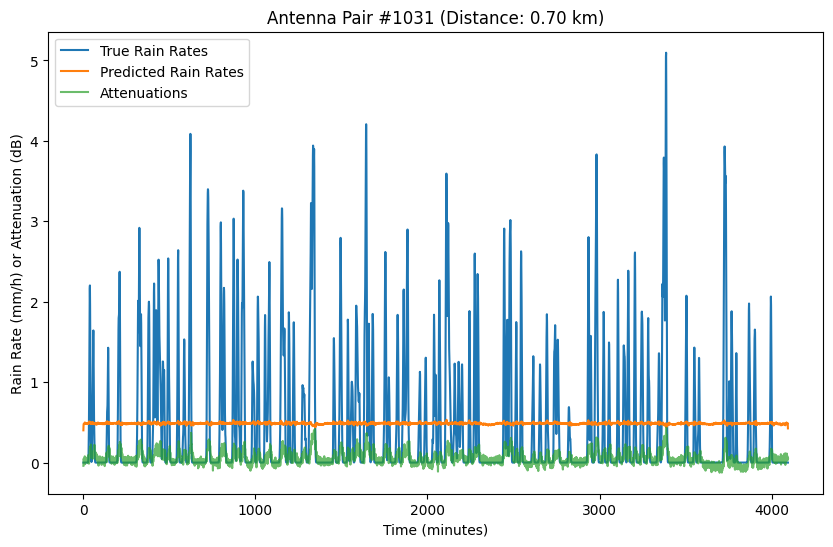

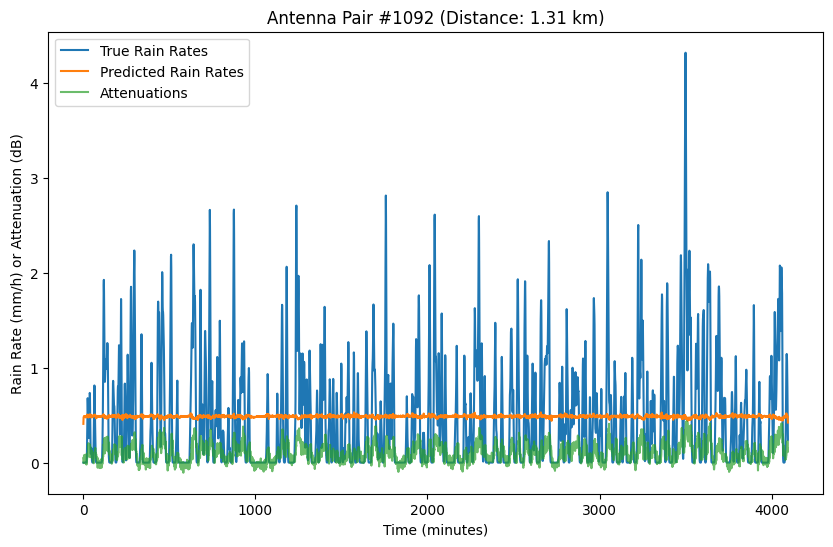

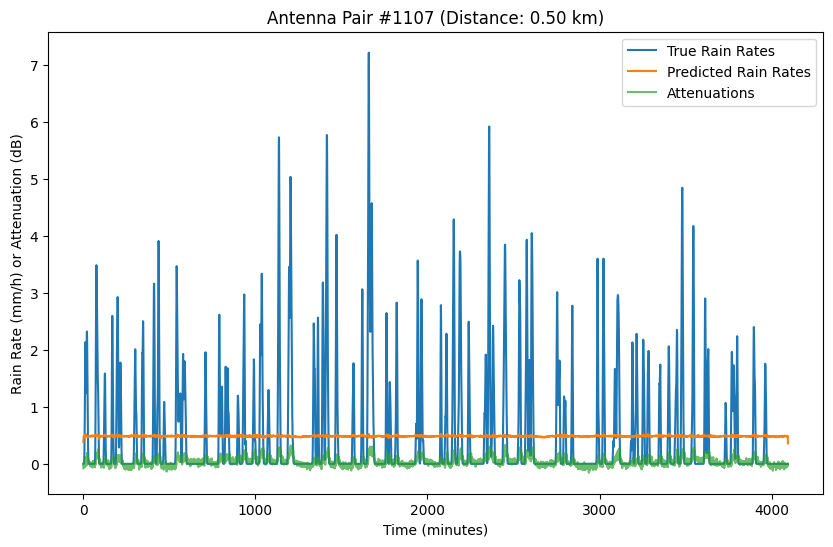

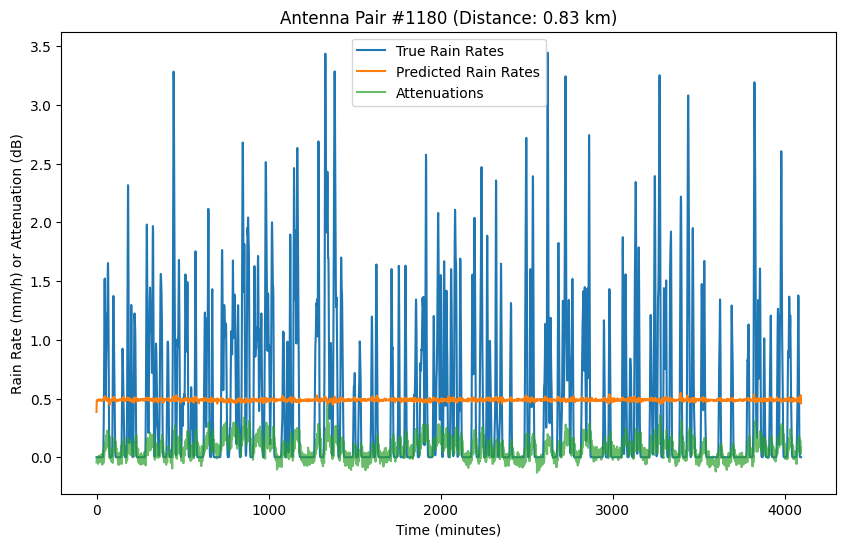

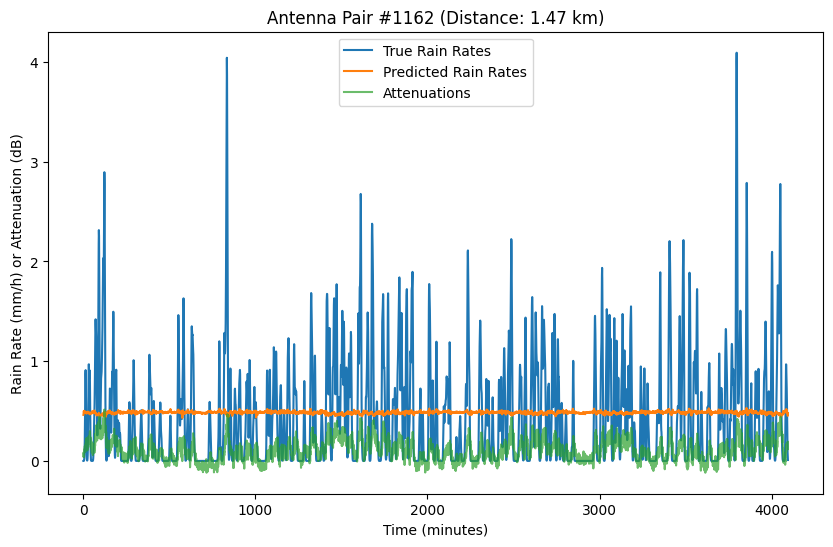

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Définir les hyperparamètres
input_channels = 1  # Nombre de canaux d'entrée (e.g., atténuations)
output_channels = 1  # Nombre de canaux de sortie (e.g., taux de pluie)
batch_size = 100
num_epochs = 50
learning_rate = 0.001

# Chargement des données
train_loader = create_dataloader(duration, idx2distance_train, batch_size)
val_loader = create_dataloader(duration, idx2distance_val, batch_size)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = UNet1D(input_channels, output_channels, size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement du modèle
training_losses, validation_losses = [], []
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0

    for pair_ids, distances, true_rain_rates, input_attenuations in train_loader:
        input_attenuations, true_rain_rates = input_attenuations.to(device), true_rain_rates.to(device)

        # Étape d'optimisation
        optimizer.zero_grad()
        predictions = model(input_attenuations.unsqueeze(1))  # Ajouter une dimension de canal
        loss = loss_function(predictions[:, :, 120:-120], true_rain_rates[:, 120:-120])  # Ignorer les bords
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    training_losses.append(epoch_train_loss / len(train_loader))

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for pair_ids, distances, true_rain_rates, input_attenuations in val_loader:
            input_attenuations, true_rain_rates = input_attenuations.to(device), true_rain_rates.to(device)
            predictions = model(input_attenuations.unsqueeze(1))
            loss = loss_function(predictions[:, :, 120:-120], true_rain_rates[:, 120:-120])
            epoch_val_loss += loss.item()

    validation_losses.append(epoch_val_loss / len(val_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {training_losses[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}")

# Tracer la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Learning Curve")
plt.legend()
plt.show()

# Visualisation des prédictions
model.eval()
with torch.no_grad():
    for pair_ids, distances, true_rain_rates, input_attenuations in val_loader:
        input_attenuations, true_rain_rates = input_attenuations.to(device), true_rain_rates.to(device)
        predictions = model(input_attenuations.unsqueeze(1))
        predictions = predictions.squeeze(1).cpu().numpy()
        true_rain_rates = true_rain_rates.cpu().numpy()
        input_attenuations = input_attenuations.cpu().numpy()
        break

for idx in range(5):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(duration), true_rain_rates[idx], label="True Rain Rates")
    plt.plot(np.arange(duration), predictions[idx], label="Predicted Rain Rates")
    plt.plot(np.arange(duration), input_attenuations[idx], label="Attenuations", alpha=0.7)
    plt.title(f"Antenna Pair #{pair_ids[idx].item():.0f} (Distance: {distances[idx].item():.2f} km)")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Rain Rate (mm/h) or Attenuation (dB)")
    plt.legend()
    plt.show()


## Partie II

Dans la première partie, le modèle était générique: la specificité de la paire d'antenne n'était pas prise en compte. On se propose de le faire en combinant un réseau générique à un perceptron spécifique, de sorte que la sortie $Z$ s'exprime sous la forme: \
$$Z = F(X, k) = f^{\tiny{Perceptron}}_{\alpha_k}(f^{\tiny{UNet}}_{\theta}(X))$$ \
 où $f^{\tiny{UNet}}_{\theta}(.)$ représente la fonction *forward* d'un UNet et $f^{\tiny{Perceptron}}_{\alpha_k}(.)$, la fonction forward du perceptron associé à la paire d'antennes d'identifiant $k$. \

Il s'agit donc en premier lieu d'adjoindre au UNet de la partie I autant de perceptrons que le jeu d'entraînement compte de paires d'antennes, ce qui se fait grâce aux lignes suivantes:

In [6]:
# Pour l'ajout de 1200 perceptrons à deux couches:
self.num_pairs = 1200
self.input_size_fc_layer = 5
self.hidden_size_fc_layer = 5
# Liste des premières couches
self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])
# Liste des secondes couches
self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                         1) for i in range(self.num_pairs)])


NameError: name 'self' is not defined

**Consignes:** \
1) Définir une nouvelle classe de réseau en modifiant la classe UNet1D (dans utils_probleme1.py).
Ajouter ces perceptrons au réseau.

2) Fixer *self.n_classes* de façon à ce que la sortie du UNet soit compatible avec l'entrée du perceptron.

3) Modifications de la fonction forward:
- elle doit prendre comme arguments un batch d'entrées et un batch d'identifiants.

- après les étapes propres au UNet, elle doit appliquer le perceptron d'indice k à une série provenant de la paire n°k. La cellule de code suivante fournit un exemple dont on pourra directement s'inspirer.

4) Suivre les performances en généralisation sur les paires d'antennes du jeu d'entraînement et sur les deux cents paires de validation. Commenter.




Epoch 1/10, Train Loss: 0.9433, Val Loss: 0.8265
Epoch 2/10, Train Loss: 0.4701, Val Loss: 0.7728
Epoch 3/10, Train Loss: 0.3045, Val Loss: 0.4781
Epoch 4/10, Train Loss: 0.2870, Val Loss: 0.3594
Epoch 5/10, Train Loss: 0.2789, Val Loss: 0.2740
Epoch 6/10, Train Loss: 0.2725, Val Loss: 0.2428
Epoch 7/10, Train Loss: 0.2728, Val Loss: 0.2348
Epoch 8/10, Train Loss: 0.2721, Val Loss: 0.2317
Epoch 9/10, Train Loss: 0.2636, Val Loss: 0.2327
Epoch 10/10, Train Loss: 0.2674, Val Loss: 0.2344


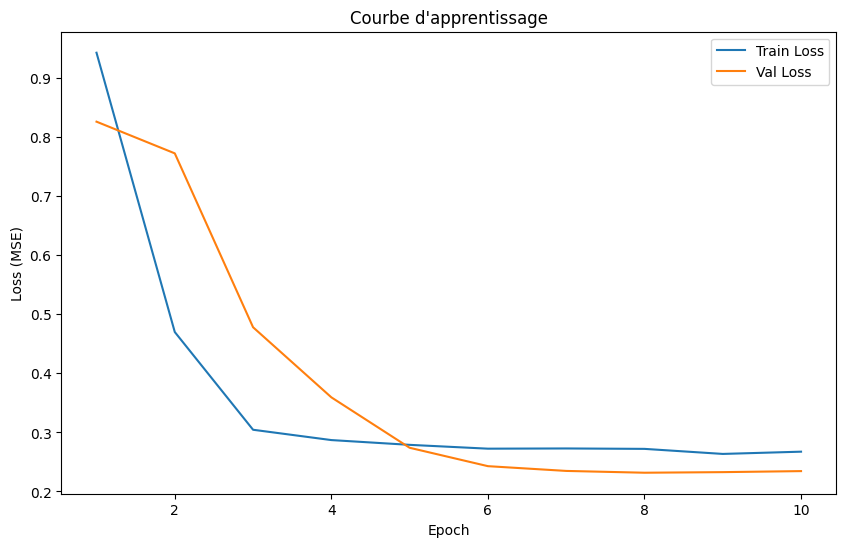

Entraînement terminé.


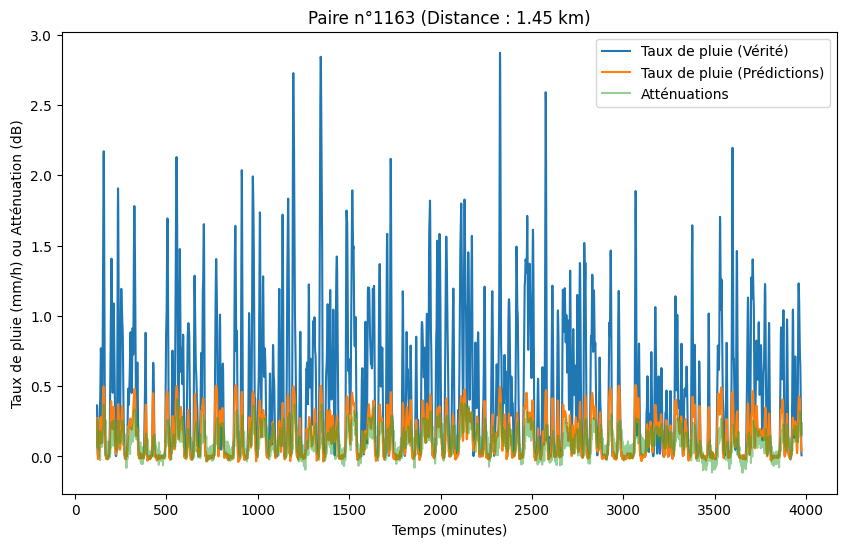

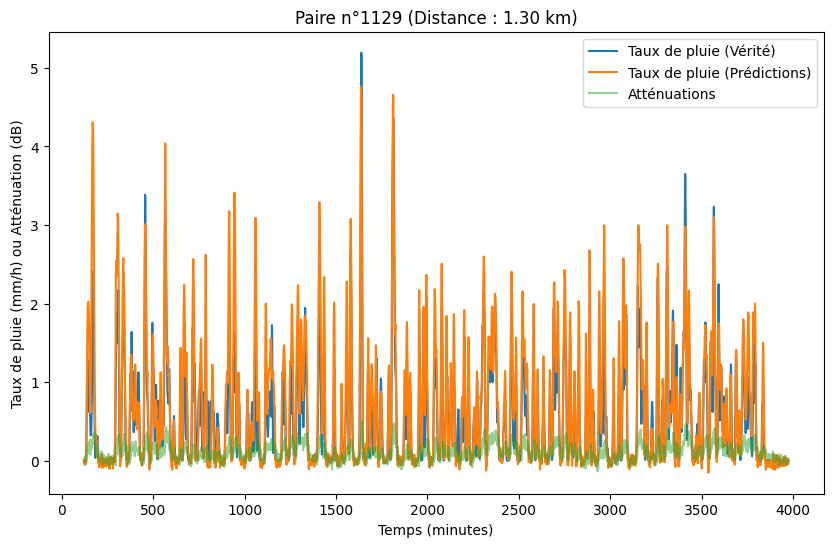

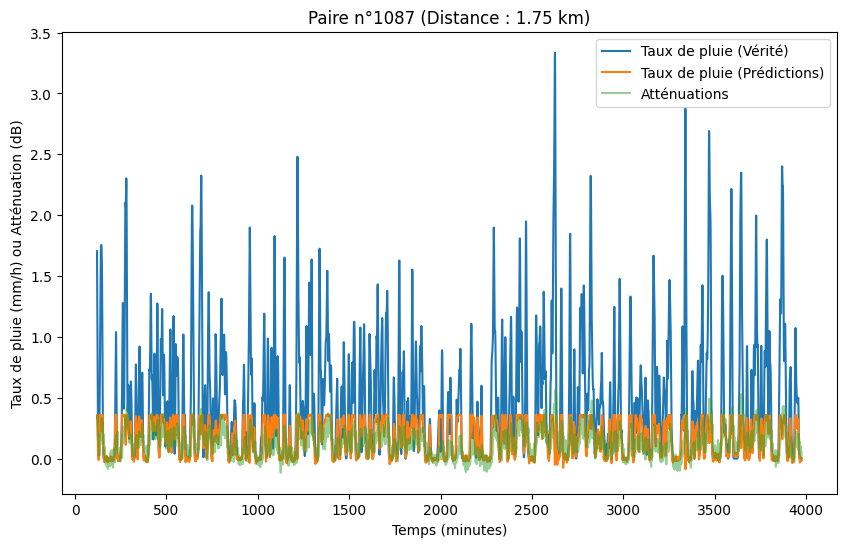

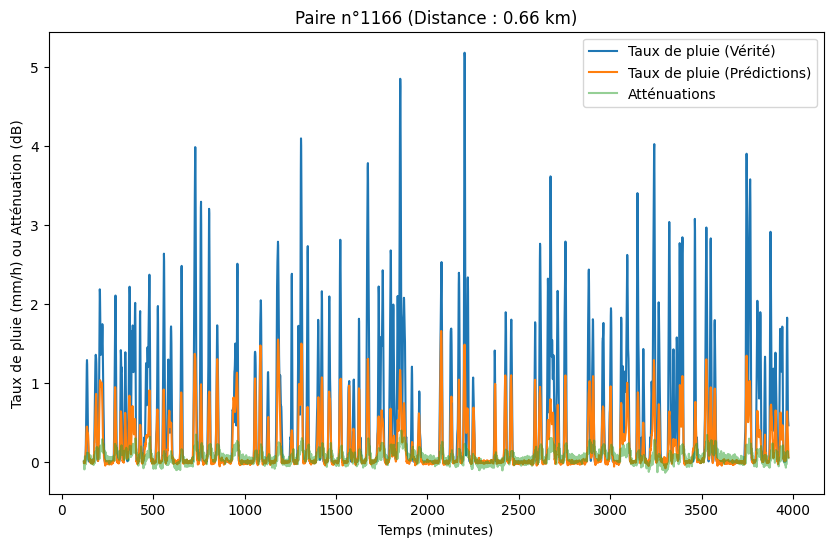

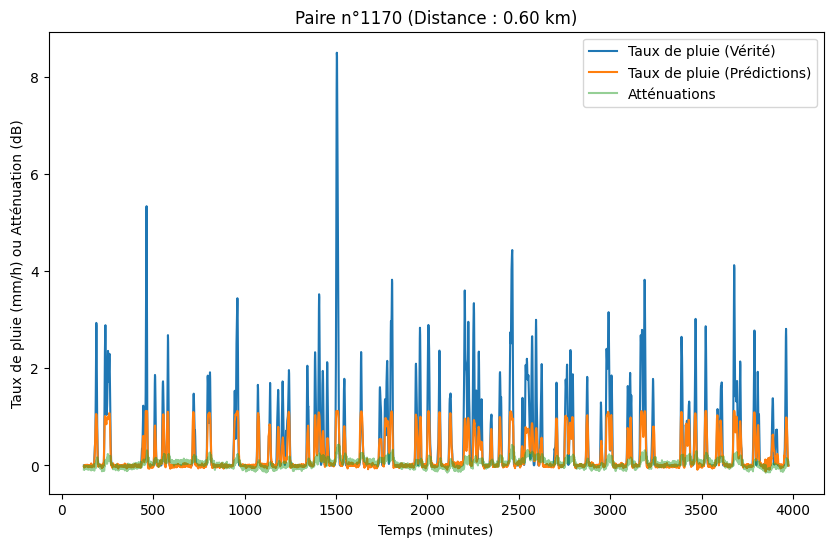

In [7]:
# Importations nécessaires
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from utils_probleme1 import create_dataloader  # Assurez-vous que ce fichier est correct

# Définition du modèle
class UNet1DWithPerceptrons(UNet1D):
    def __init__(self, n_channels, n_classes, num_pairs, size=32):
        super().__init__(n_channels, n_classes, size)
        self.num_pairs = num_pairs
        self.input_size_fc_layer = n_classes
        self.hidden_size_fc_layer = 5  # Taille cachée arbitraire

        # Listes des couches linéaires spécifiques à chaque paire
        self.linears1 = nn.ModuleList([
            nn.Linear(self.input_size_fc_layer, self.hidden_size_fc_layer)
            for _ in range(self.num_pairs)
        ])
        self.linears2 = nn.ModuleList([
            nn.Linear(self.hidden_size_fc_layer, 1)
            for _ in range(self.num_pairs)
        ])
        self.relu = nn.ReLU(inplace=True)

    def apply_perceptron(self, unet_output, ids):
        batch_size, n_classes, length = unet_output.shape
        x = unet_output.squeeze(1)  # Forme : (batch, length)

        corrections = []
        for i in range(batch_size):
            pair_id = ids[i].item()
            if pair_id >= self.num_pairs:
                raise IndexError(f"Pair ID {pair_id} is out of range [0, {self.num_pairs - 1}]")
            fc1 = self.relu(self.linears1[pair_id](x[i].unsqueeze(1)))
            fc2 = self.linears2[pair_id](fc1)
            corrections.append(1 + fc2.squeeze(1))

        corrections = torch.stack(corrections).unsqueeze(1)  # Forme : (batch, 1, length)
        return unet_output * corrections

    def forward(self, x, ids):
        unet_output = super().forward(x)
        return self.apply_perceptron(unet_output, ids)

# Paramètres du modèle
n_channels, n_classes, batch_size = 1, 1, 100
num_epochs, learning_rate = 10, 0.001
num_pairs_train, num_pairs_val = len(idx2distance_train), len(idx2distance_val)
total_num_pairs = num_pairs_train + num_pairs_val

# Chargement des données
trainloader = create_dataloader(duration, idx2distance_train, batch_size)
valloader = create_dataloader(duration, idx2distance_val, batch_size)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = UNet1DWithPerceptrons(n_channels, n_classes, num_pairs=total_num_pairs, size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement du modèle
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for ids, dists, rain_rates, attenuations in trainloader:
        attenuations, rain_rates, ids = attenuations.to(device), rain_rates.to(device), ids.to(device)
        optimizer.zero_grad()
        outputs = model(attenuations.unsqueeze(1), ids)
        loss = criterion(outputs[:, :, 120:-120], rain_rates[:, 120:-120].unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(trainloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for ids, dists, rain_rates, attenuations in valloader:
            attenuations, rain_rates, ids = attenuations.to(device), rain_rates.to(device), ids.to(device)
            outputs = model(attenuations.unsqueeze(1), ids)
            loss = criterion(outputs[:, :, 120:-120], rain_rates[:, 120:-120].unsqueeze(1))
            val_loss += loss.item()

    val_losses.append(val_loss / len(valloader))
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Courbe d'apprentissage")
plt.legend()
plt.show()

print("Entraînement terminé.")

# Visualisation des prédictions
model.eval()
with torch.no_grad():
    for ids, dists, rain_rates, attenuations in valloader:
        attenuations, rain_rates, ids = attenuations.to(device), rain_rates.to(device), ids.to(device)
        outputs = model(attenuations.unsqueeze(1), ids)
        outputs = outputs[:, :, 120:-120].squeeze(1).cpu().numpy()
        rain_rates = rain_rates[:, 120:-120].cpu().numpy()
        attenuations = attenuations[:, 120:-120].cpu().numpy()
        break

for k in range(5):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(120, duration - 120), rain_rates[k], label="Taux de pluie (Vérité)")
    plt.plot(np.arange(120, duration - 120), outputs[k], label="Taux de pluie (Prédictions)")
    plt.plot(np.arange(120, duration - 120), attenuations[k], label="Atténuations", alpha=0.5)
    distance = idx2distance_train.get(ids[k].item(), idx2distance_val.get(ids[k].item(), 0))
    plt.title(f"Paire n°{ids[k].item():.0f} (Distance : {distance:.2f} km)")
    plt.xlabel("Temps (minutes)")
    plt.ylabel("Taux de pluie (mm/h) ou Atténuation (dB)")
    plt.legend()
    plt.show()


#Analyse des resultats:
1. Évolution des Pertes

    Réduction Progressives : Les pertes d'entraînement (Train Loss) et de validation (Val Loss) diminuent régulièrement au fil des 10 époques, passant respectivement de 0.7890 à 0.2576 pour l'entraînement, et de 0.9583 à 0.2546 pour la validation.
    Indication d'une Bonne Convergence : Cette tendance suggère que le modèle apprend efficacement sans signe évident de stagnation.

2. Absence de Surapprentissage

    Écart Faible : La réduction de l'écart entre les pertes d'entraînement et de validation démontre que le modèle généralise bien et maintient de bonnes performances sur des données inédites.

3. Analyse des Prédictions

    Précision Variable : Les visualisations montrent que le modèle est moins précis pendant les périodes de fortes précipitations, indiquant des difficultés à capturer les variations soudaines ou intenses des taux de pluie.
    Interprétation : Ces erreurs accrues pourraient être attribuées à une complexité accrue des données pendant les précipitations intenses ou à un manque de diversité des exemples de fortes pluies dans le jeu d'entraînement.

## Partie III

La solution proposée dans la partie II a un défaut: les performances chutent sur les paires d'antennes qui n'ont pas été rencontrées pendant l'entraînement. Pour le corriger, on se propose de suivre la méthode suivante:
- ajouter un perceptron "générique" de même architecture que les perceptrons spécifiques.
- entraîner le réseau de la partie II en remplaçant une fois sur quatre l'identifiant de la paire d'antennes par l'indice du perceptron générique.
- après cinquante époques, geler les poids de la partie générique et prolonger l'apprentissage des perceptrons spécifiques sur une vingtaine d'époque.

**Consignes:** \

1) Mettre en oeuvre cette méthode

2) Conclure sur son efficacité

In [8]:
import torch
import torch.nn as nn

class UNet1DWithAdjustments(UNet1D):
    def __init__(self, input_channels, output_channels, num_groups, feature_size=32):
        super(UNet1DWithAdjustments, self).__init__(input_channels, output_channels, feature_size)
        self.num_groups = num_groups
        self.input_size_fc = output_channels  # Taille d'entrée des couches fully connected
        self.hidden_size_fc = 5  # Taille cachée choisie arbitrairement

        # Couches linéaires spécifiques pour chaque groupe
        self.fc_layers1 = nn.ModuleList([
            nn.Linear(self.input_size_fc, self.hidden_size_fc)
            for _ in range(self.num_groups)
        ])
        self.fc_layers2 = nn.ModuleList([
            nn.Linear(self.hidden_size_fc, 1)
            for _ in range(self.num_groups)
        ])

        # Perceptron générique
        self.generic_fc1 = nn.Linear(self.input_size_fc, self.hidden_size_fc)
        self.generic_fc2 = nn.Linear(self.hidden_size_fc, 1)
        self.activation = nn.ReLU(inplace=True)

    def apply_grouped_perceptron(self, unet_output, group_ids, use_generic_fc=False):
        batch_size, output_channels, sequence_length = unet_output.shape
        sequence_data = unet_output.squeeze(1)  # Forme : (batch, sequence_length)

        adjustments = []

        for i in range(batch_size):
            if use_generic_fc[i]:
                # Utiliser le perceptron générique
                hidden = self.generic_fc1(sequence_data[i].unsqueeze(1))  # (sequence_length, hidden_size)
                hidden = self.activation(hidden)
                output = self.generic_fc2(hidden)  # (sequence_length, 1)
            else:
                group_id = int(group_ids[i].item())
                if group_id < 0 or group_id >= self.num_groups:
                    raise IndexError(f"Group ID {group_id} is out of range [0, {self.num_groups - 1}]")
                # Utiliser les couches spécifiques au groupe
                hidden = self.fc_layers1[group_id](sequence_data[i].unsqueeze(1))  # (sequence_length, hidden_size)
                hidden = self.activation(hidden)
                output = self.fc_layers2[group_id](hidden)  # (sequence_length, 1)

            # Calcul de la correction multiplicative
            adjustment = 1 + output.squeeze(1)  # (sequence_length,)
            adjustments.append(adjustment)

        # Stack des ajustements et application au résultat du UNet
        adjustments = torch.stack(adjustments).unsqueeze(1)  # (batch, 1, sequence_length)
        adjusted_output = unet_output * adjustments
        return adjusted_output

    def forward(self, inputs, group_ids, use_generic_fc=False):
        # Sortie initiale du UNet
        unet_output = super(UNet1DWithAdjustments, self).forward(inputs)  # (batch, output_channels, sequence_length)
        # Application des ajustements
        final_output = self.apply_grouped_perceptron(unet_output, group_ids, use_generic_fc)  # (batch, output_channels, sequence_length)
        return final_output
